# Example from Image Processing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

Here we'll take a look at a simple facial recognition example.
This uses a dataset available within scikit-learn consisting of a
subset of the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)
data.  Note that this is a relatively large download (~200MB) so it may
take a while to execute.

In [2]:
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                                       data_home='datasets')
lfw_people.data.shape

(1288, 1850)

If you're on a unix-based system such as linux or Mac OSX, these shell commands
can be used to see the downloaded dataset:

In [3]:
!ls datasets

lfw_home  sentiment140	smsspam  titanic  trainingandtestdata.zip


In [4]:
!du -sh datasets/lfw_home

297M	datasets/lfw_home


Once again, let's visualize these faces to see what we're working with:

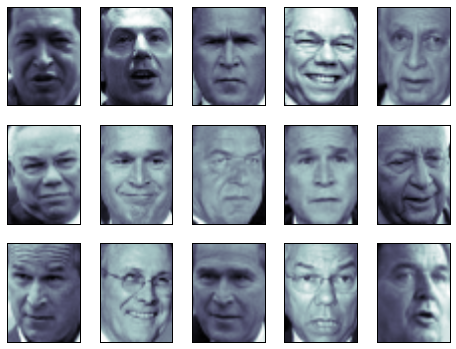

In [5]:
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap=plt.cm.bone)

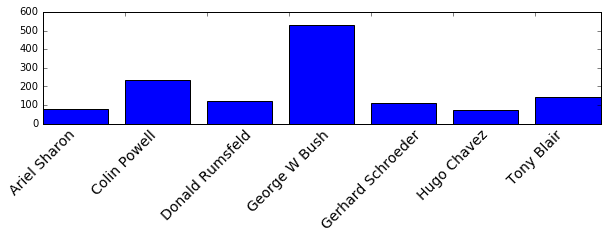

In [6]:
import numpy as np
plt.figure(figsize=(10, 2))

unique_targets = np.unique(lfw_people.target)
counts = [(lfw_people.target == i).sum() for i in unique_targets]

plt.xticks(unique_targets, lfw_people.target_names[unique_targets])
locs, labels = plt.xticks()
plt.setp(labels, rotation=45, size=14)
_ = plt.bar(unique_targets, counts)

One thing to note is that these faces have already been localized and scaled
to a common size.  This is an important preprocessing piece for facial
recognition, and is a process that can require a large collection of training
data.  This can be done in scikit-learn, but the challenge is gathering a
sufficient amount of training data for the algorithm to work

Fortunately, this piece is common enough that it has been done.  One good
resource is [OpenCV](http://opencv.willowgarage.com/wiki/FaceRecognition), the
*Open Computer Vision Library*.

We'll perform a Support Vector classification of the images.  We'll
do a typical train-test split on the images to make this happen:

In [7]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    lfw_people.data, lfw_people.target, random_state=0)

print(X_train.shape, X_test.shape)

((966, 1850), (322, 1850))


## Preprocessing: Principal Component Analysis

1850 dimensions is a lot for SVM.  We can use PCA to reduce these 1850 features to a manageable
size, while maintaining most of the information in the dataset.  Here it is useful to use a variant
of PCA called ``RandomizedPCA``, which is an approximation of PCA that can be much faster for large
datasets.  We saw this method in the previous notebook, and will use it again here:

In [8]:
from sklearn import decomposition
pca = decomposition.RandomizedPCA(n_components=150, whiten=True,
                                 random_state=1999)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

(966, 150)
(322, 150)


These projected components correspond to factors in a linear combination of
component images such that the combination approaches the original face. In general, PCA can be a powerful technique for preprocessing that can greatly improve classification performance.

## Doing the Learning: Support Vector Machines

Now we'll perform support-vector-machine classification on this reduced dataset:

In [9]:
from sklearn import svm
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Finally, we can evaluate how well this classification did.  First, we might plot a
few of the test-cases with the labels learned from the training set:

/home/bvdeenen/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/bvdeenen/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/bvdeenen/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape

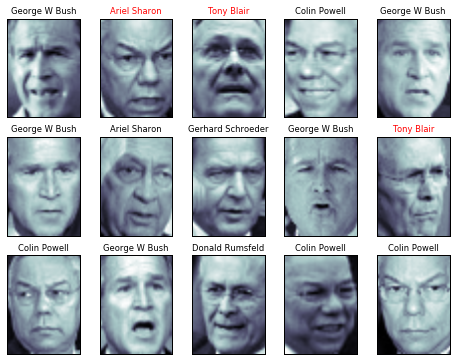

In [10]:
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape((50, 37)), cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i])[0]
    color = 'black' if y_pred == y_test[i] else 'red'
    ax.set_title(lfw_people.target_names[y_pred], fontsize='small', color=color)

The classifier is correct on an impressive number of images given the simplicity
of its learning model!  Using a linear classifier on 150 features derived from
the pixel-level data, the algorithm correctly identifies a large number of the
people in the images.

Again, we can
quantify this effectiveness using ``clf.score``

In [11]:
print(clf.score(X_test_pca, y_test))

0.844720496894


## Final Note

Here we have used PCA "eigenfaces" as a pre-processing step for facial recognition.
The reason we chose this is because PCA is a broadly-applicable technique, which can
be useful for a wide array of data types.  For more details on the eigenfaces approach, see the original paper by [Turk and Penland, Eigenfaces for Recognition](http://www.face-rec.org/algorithms/PCA/jcn.pdf). Research in the field of facial recognition has moved much farther beyond this paper, and has shown specific feature extraction methods can be more effective. However, eigenfaces is a canonical example of machine learning "in the wild", and is a simple method with good results.